# Stack and Test Models

In [1]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
import math
import matplotlib
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

plt.style.use('ggplot')

We load the test set

In [141]:
# Load the test set
df = pd.read_csv('./data/new_test.csv')
df.drop(['Unnamed: 0', 'Id'], axis=1, inplace=True)

# Load categorical variables
numerical = pickle.load(open('./tmp/numerical.list', 'rb'))
numerical = list(set(numerical)-set(['SalePrice']))

df.shape

(1459, 278)

In the train set we noticed that some variables seem to be entered by mistake or represent a very unusual property (i.e. 5000 sq feet garage). We impute the values that differ from the mean by more than 5 standard deviation with the mean.

In [142]:
def correctWrong(series, threshold=5):
    '''
    A helper function that returns series with variables that deviate from the mean by more than a threshold
    imputed by the mean
    '''
    
    mean = np.mean(series)
    std = np.std(series)
    
    series = series.map(lambda x: x if x< (mean + threshold*std) else mean)
    
    return series
    

df[numerical] = df[numerical].apply(correctWrong)

Transform skewed features

In [143]:
# Load list of skewed features
sk_feat = pickle.load(open('./tmp/sk_feat.list', 'rb'))

# Apply Log+1 transformation
df[sk_feat] = np.log1p(df[sk_feat])

Create one hot variables

In [144]:
X=df.copy()

## Predictions using linear models

Load models

In [145]:
models_comb = pickle.load(open('./tmp/models_comb', 'rb'))
models_comb

,model,score
0,model1a,0.041812
1,model1b,0.040537
2,model2a,0.054066
3,model2b,0.054065
4,model3,0.072540


### All variables

Linear regression with ridge regularization

In [146]:
model1a = pickle.load(open('./tmp/model1a.model', 'rb'))
model1a

Ridge(alpha=array([7.9]), copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [147]:
a1 = np.exp(model1a.predict(X))
a1.shape

(1459,)

Linear regression with LASSO regularization

In [148]:
model1b = pickle.load(open('./tmp/model1b.model', 'rb'))
model1b

Lasso(alpha=0.00015000000000000001, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [149]:
b1 = np.exp(model1b.predict(X))
b1.shape

(1459,)

### Selected variables

Load selected variables

In [150]:
selected = pickle.load(open('./tmp/feaure_list_dt.list', 'rb'))
selected

['OverallQual',
 'GrLivArea',
 'CentralAir_Y',
 'TotalBsmtSF',
 'GarageCars',
 'KitchenAbvGr',
 '1stFlrSF',
 'BsmtFinSF1',
 'MSZoning_RM',
 '2ndFlrSF',
 'OverallCond',
 'GarageArea',
 'YearBuilt',
 'LotArea',
 'YearRemodAdd',
 'Neighborhood_Sawyer',
 'BsmtUnfSF',
 'MoSold',
 'PavedDrive_Y',
 'TotRmsAbvGrd',
 'GarageQual_TA',
 'LotFrontage',
 'OpenPorchSF']

In [151]:
X_sel = X[selected]
X_sel.shape

(1459, 23)

Linear regression with ridge regularization

In [152]:
model2a = pickle.load(open('./tmp/model2a.model', 'rb'))
model2a

Ridge(alpha=array([0.8]), copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [153]:
a2 = np.exp(model2a.predict(X_sel))
a2.shape

(1459,)

Linear regression with LASSO regularization

In [154]:
model2b = pickle.load(open('./tmp/model2b.model', 'rb'))
model2b

Lasso(alpha=0.00015000000000000001, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [155]:
b2 = np.exp(model2b.predict(X_sel))
b2.shape

(1459,)

## PCA

In [156]:
pca = decomposition.PCA(n_components=18)
pca.fit(X)
transformed = pca.transform(X)

explained_variance = np.var(transformed, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

# Find how may components explain 98% of variance
expl = np.cumsum(explained_variance_ratio)
expl


array([0.49764754, 0.788322  , 0.92928397, 0.9651994 , 0.99601059,
       0.99836085, 0.99960987, 0.9999327 , 0.99994876, 0.99995945,
       0.99996846, 0.99997675, 0.99998284, 0.99998793, 0.99999174,
       0.99999491, 0.99999778, 1.        ])

In [157]:
model3 = pickle.load(open('./tmp/model3.model', 'rb'))
model3

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [158]:
m3 = np.exp(model3.predict(transformed))
m3.shape

(1459,)

## TreeRegressor

In [159]:
tree = pickle.load(open('./tmp/tree.model', 'rb'))
tree

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=43, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [160]:
tr = np.exp(tree.predict(X))
tr.shape

(1459,)

## XGB

In [161]:
xgb_mod = pickle.load(open('./tmp/xgb_mod.model', 'rb'))
xgb_mod

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=nan, n_estimators=60,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [162]:
gb = np.exp(xgb_mod.predict(X))
gb.shape

(1459,)

## Combining 

Let's comnine all predictions

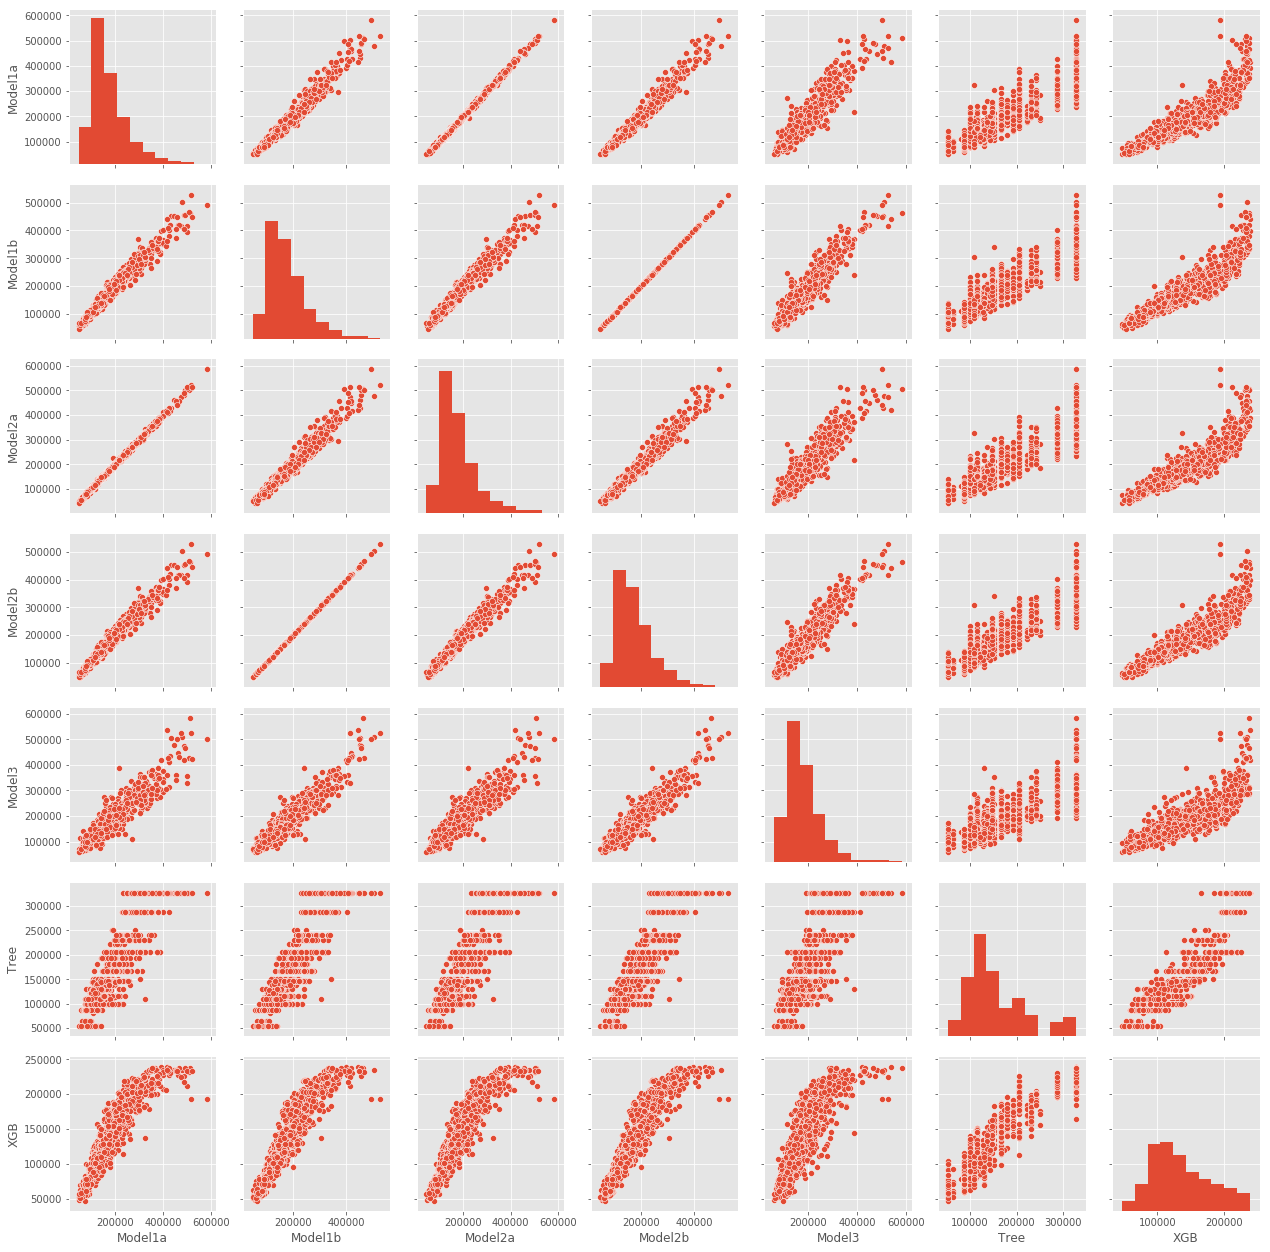

In [163]:
predictions = pd.DataFrame([a1, a2, b1, b2, m3, tr, gb]).T
predictions.columns = ['Model1a', 'Model1b', 'Model2a', 'Model2b', 'Model3', 'Tree', 'XGB']
sns.pairplot(predictions)

Weighting the predictions.

In [252]:
def PredictAll(models, weights, X, y):
    
    '''
    A helper function that returns the prediction rmsle given models and their stacking weights
    '''
    
    y_pred = [] #Place holder
    
    for i, model in enumerate(models):
        y_hat = model.predict(X[i])
        y_pred = y_pred + [y_hat]
    
    # Calculate consensus prediction
    y_pred = np.array(y_pred)
    y_pred = weights.dot(y_pred)
    
    # Calculate rmsle
    rmsle = np.sqrt(np.mean((y_pred - y)**2))
    
    return rmsle
    
                        

Perform cross-validation of weights

In [296]:
models_all = [model1a, model1b, model2a, model2b, model3, tree, xgb_mod]

nsims = 100

weight_store = []
test_store = []
train_store = []

for sim in range(nsims):
    
    weights = np.random.uniform(low=0, high=1, size=7)
    weights /= sum(weights)
    
    rows = X.index.values
    np.random.shuffle(rows)
    cut = int(0.8*X.shape[0])
    train, test = rows[:cut], rows[cut:]

    X_train = [X.iloc[train,:], X.iloc[train,:], X_sel.iloc[train,:], X_sel.iloc[train,:],\
               transformed[train], X.iloc[train,:], X.iloc[train,:]]
    y_train = np.log(answer.SalePrice)[train]

    rmsle_train = PredictAll(models=models_all, weights=weights, X=X_train, y=y_train)

    X_test = [X.iloc[test,:], X.iloc[test,:], X_sel.iloc[test,:], X_sel.iloc[test,:],\
               transformed[test], X.iloc[test,:], X.iloc[test,:]]
    y_test = np.log(answer.SalePrice)[test]

    rmsle_test = PredictAll(models=models_all, weights=weights, X=X_test, y=y_test)

    test_store = test_store + [rmsle_test]
    train_store = train_store + [rmsle_train]
    weight_store = weight_store + [weights]



In [306]:
res = pd.DataFrame({'Weights':weight_store, 'Test':test_store, 'Train':train_store}).sort_values('Train')
res.Weights[0]

array([0.15345194, 0.14385483, 0.15239606, 0.27788636, 0.04573553,
       0.02587212, 0.20080316])

In [312]:
wghts_new = np.array([0.15345194, 0.14385483, 0.15239606, 0.27788636, 0.04573553, 0.02587212, 0.20080316])
PredictAll(models=models_all, weights=wghts_new, X=X_train, y=y_train)

0.14620999288556882

In [223]:
#Load all models results
tree_comb = pickle.load(open('./tmp/tree_comb', 'rb'))

models = models_comb.append(tree_comb).reset_index().drop('index', axis=1)
models

#Calculate weights
sm = np.sum(1/models['score'])
models['wght'] = models.score.apply(lambda x: (1/x) / sm) 

# Apply weights to predictions
weights = np.array(models['wght']).T
#weights = np.array([0.20, 0.20, 0.20, 0.20, 0, 0, 0.2]).T
pred_mat = np.matrix(predictions)

prediction = weights.dot(pred_mat.T)
prediction.shape

(1, 1459)

In [224]:
prediction = np.array(prediction)
prediction.shape

(1, 1459)

In [225]:
prediction

array([[115791.18215309, 152672.52756142, 175424.40743521, ...,
        173702.4337733 , 116609.2406035 , 219793.66136464]])

In [226]:
# Create a dataframe

# Load the test set
df = pd.read_csv('./data/new_test.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

#Reshape prediction

submission = pd.DataFrame({'Id':df['Id'], 'Predicted': prediction[0,:]})

submission.head()


,Id,Predicted
0,1461,115791.182153
1,1462,152672.527561
2,1463,175424.407435
3,1464,188845.567096
4,1465,191737.622224


## Use real data

We find the answer key in R package https://cran.r-project.org/web/packages/AmesHousing/index.html

In [227]:
# Load answer key
answer = pd.read_csv('./data/answerkey.csv', index_col=0)
answer.head()

,Id,SalePrice
0,1461,105000
1,1462,172000
2,1463,189900
3,1464,195500
4,1465,191500


In [228]:
# Merge with prediction

result = pd.merge(answer, submission, on='Id', how='left')
result.head()

,Id,SalePrice,Predicted
0,1461,105000,115791.182153
1,1462,172000,152672.527561
2,1463,189900,175424.407435
3,1464,195500,188845.567096
4,1465,191500,191737.622224


We greaphically analyze our predictions

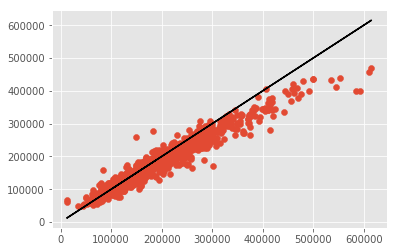

In [229]:
#Plot 

plt.scatter(result['SalePrice'],result['Predicted'])
plt.plot(result['SalePrice'], result['SalePrice'], c='black')

We calculate RMSLE using natural logarithm of prices

In [232]:
rmsle = np.sqrt(np.mean((np.log(result['SalePrice']) - np.log(result['Predicted']))**2))
rmsle

0.13464086326139657

... and the logarithm with base 10.

In [233]:
rmsle10 = np.sqrt(np.mean((np.log10(result['SalePrice']) - np.log10(result['Predicted']))**2))
rmsle10

0.05847378395311489